In [17]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# The Premise

When we want to solve more specific problems, we'll need to make our own datasets and load them to pytorch, this brings 3 problems

1. `How to Get the Data?`
2. `How to Format the Data?`
3. `How to Load Data into pytorch?`

Different Domain Libraries are used to handle different types of data sources, these are some of them

1. `TorchVision`
2. `TorchText`
3. `TorchAudio`

In this tutorial, we will look at loading image data from Food101, so the dataset we are making is using torchvision<br>
As well as making a model to predict on our custom dataset, just cause lol

Also, here are some ways the Pytorch team was able to improve the accuracy of their image classification model, maybe we will encounter them down the road

<img src="Techniques.png" alt="The WorkFlow" width="1000">

# The Data

When starting out in ML projects, it's important to try things on the small scale first before we increase the scale

The reason is to speed up how fast we can experiment with data

## Getting + Format Data

The Dataset is downloaded from github, and unzipping it, it is already in the format we want (then delete it)

In [1]:
#The library that allows us to interact with web services and APIs
import requests

#As the name suggests... allows us to unzip or zip files
import zipfile

#Setting up directories, folders, getting things to places
from pathlib import Path

#For Deleting the Zip File After Download
import os


#Setup path to a folder
data_path = Path("Data/")


#Creating data folder
if data_path.is_dir():
    print(f"{data_path} directory already exists, skipping download")
else:
    print(f"{data_path} does not exist, creating directory")
    data_path.mkdir(parents=True, exist_ok=True)


    #Downloading Data Zip file, wb means write binary
    with open(data_path/"pizza_steak_sushi.zip","wb") as a:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading image data...")
        a.write(request.content)
    
    
    #Unzipping Files in Zip
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as images:
        print("Unzipping Image Data")
        images.extractall(data_path)


    # Delete the zip file
    zip_file_path = data_path / "pizza_steak_sushi.zip"
    try:
        os.remove(zip_file_path)
        print(f"{zip_file_path} deleted successfully.")
    except OSError:
        print(f"Error: OSError")

Data directory already exists, skipping download


## Explore Data

Sees all our directories and all our files with os's tree

In [2]:
#Creates a tree showing... those three things
for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"In {dirpath} : There are {len(dirnames)} directories and {len(filenames)} images")

In Data : There are 2 directories and 0 images
In Data\test : There are 3 directories and 0 images
In Data\test\pizza : There are 0 directories and 25 images
In Data\test\steak : There are 0 directories and 19 images
In Data\test\sushi : There are 0 directories and 31 images
In Data\train : There are 3 directories and 0 images
In Data\train\pizza : There are 0 directories and 78 images
In Data\train\steak : There are 0 directories and 75 images
In Data\train\sushi : There are 0 directories and 72 images


See random samples from our data with PIL

Image Belongs To: train
Image Class: steak
Image Width: 512
Image Height: 512


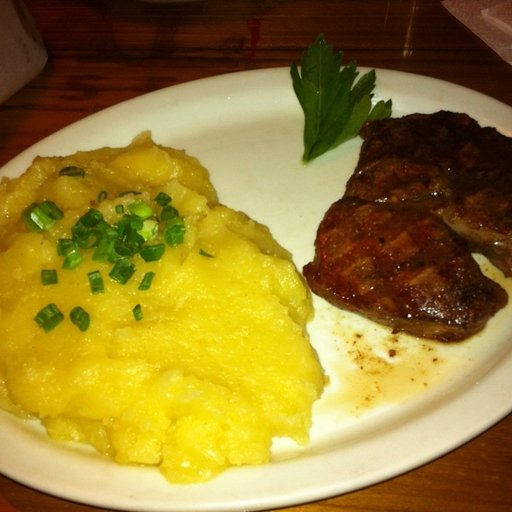

In [3]:
import random
from PIL import Image

# Get all the image paths with glob, Glob Iterate over the path's subtree and yield all existing files
# The format inside glob basically stands for how should Glob format the files' path
# */*.jpg = test/10123454.jpg, or */*.jpg = train/1023467.jpg, who knows
image_path_list = list(data_path.glob("*/*/*.jpg"))


# Pick a Random image's path
random_image_path = random.choice(image_path_list)


# Knowing the parent folder name
image_class = random_image_path.parent.stem
test_or_train = random_image_path.parent.parent.stem


# Opening it Up
image = Image.open(random_image_path)
print(f"Image Belongs To: {test_or_train}")
print(f"Image Class: {image_class}")
print(f"Image Width: {image.width}")
print(f"Image Height: {image.height}")
image

See the same random sample from our data with MatPlotLib

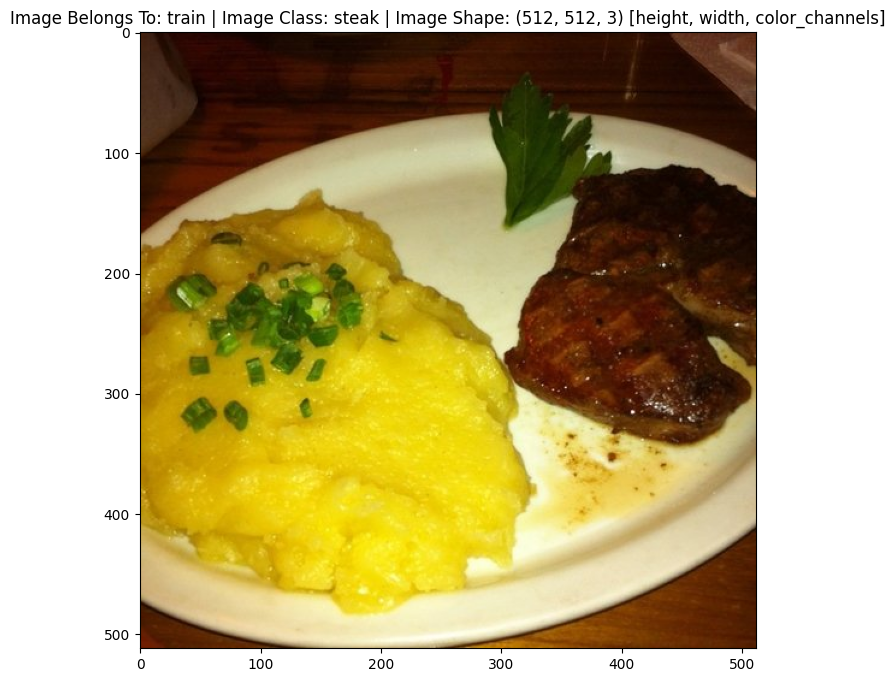

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#Turning Image into Array
image_array = np.asarray(image)

#Plotting it out
plt.figure(figsize=(8,8))
plt.imshow(image_array)
plt.title(f"Image Belongs To: {test_or_train} | Image Class: {image_class} | Image Shape: {image_array.shape} [height, width, color_channels]");

## Loading Data Into Pytorch

### Option 1, using `ImageFolder`

1. Turn target data into tensors using `transforms.ToTensor`, specifically for images
2. Turn all our data into a dataset `torch.utils.data.Dataset` and use `torch.utils.data.DataLoader`

In [5]:
# Use ImageFolder to create dataset(s)
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dir = data_path/"train"
test_dir = data_path/"test"


#This step describes the transformations of images before turning into tensors
data_transform = transforms.Compose([transforms.Resize(size=(128, 128)), transforms.ToTensor()])


#target folder of images, and transforms to perform on data (images)
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform) 
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)


These datasets that we've made have some useful attributes

1. `dataset.samples` - A list of lists, with all the samples' path and respective labels
2. `dataset.classes` - A list of possible labels
3. `dataset.class_to_idx` - A dictionary that maps numbers to labels

Now we'll see how our images are after being transformed into tensors

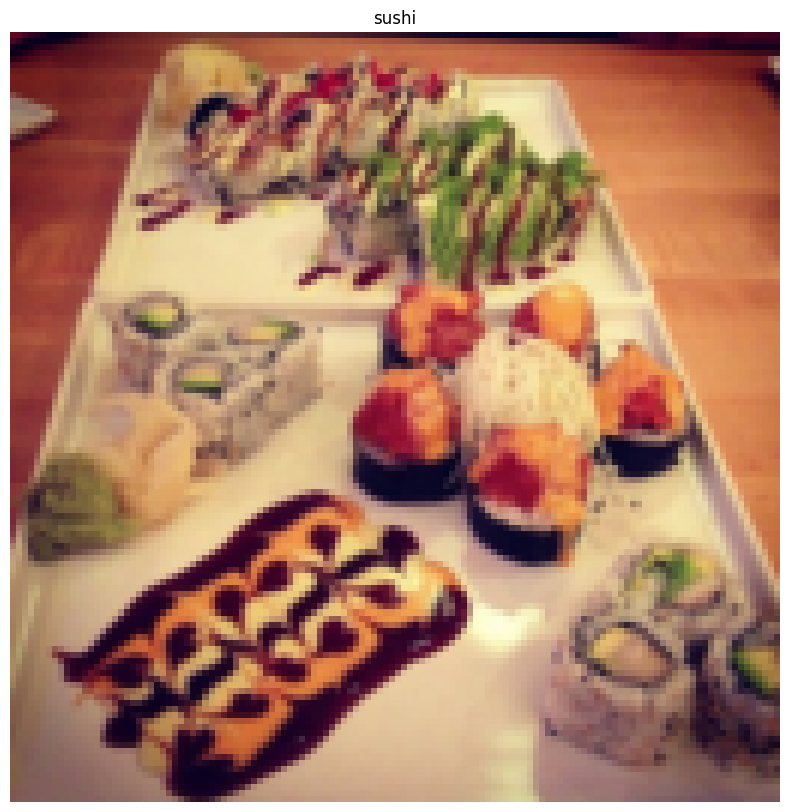

In [6]:
img, label = random.choice(train_data)
img_permute = img.permute(1, 2, 0)
class_dic = train_data.classes


plt.figure(figsize=(10, 10))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_dic[label]);

#### Converting Datasets to Dataloaders

Ok, but why? Well, if we load everything in our dataset at once to our GPU and start training, we potentially run out of VRAM

Dataloaders allow us to load data in batches, shuffle them, and generally makes it easier to integrate into training and testing loops

In [7]:
#batch size is how many samples in a batch
#num workers is how many cores you want the cpu to be running this dataloader on
train_dataloader = DataLoader(dataset=train_data, batch_size=5, num_workers=0, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=0, shuffle=False)

train_features, train_labels = next(iter(train_dataloader))
train_features, train_labels

(tensor([[[[0.0667, 0.0588, 0.0667,  ..., 0.0824, 0.0667, 0.0471],
           [0.0745, 0.0667, 0.0706,  ..., 0.0902, 0.0784, 0.0588],
           [0.0980, 0.1059, 0.0863,  ..., 0.0706, 0.0627, 0.0471],
           ...,
           [0.4745, 0.4784, 0.4667,  ..., 0.5333, 0.5490, 0.5490],
           [0.4902, 0.4941, 0.5098,  ..., 0.8667, 0.8745, 0.8667],
           [0.5216, 0.5020, 0.5059,  ..., 0.9490, 0.9569, 0.9529]],
 
          [[0.0784, 0.0706, 0.0784,  ..., 0.0863, 0.0745, 0.0588],
           [0.0863, 0.0784, 0.0824,  ..., 0.0941, 0.0824, 0.0745],
           [0.1137, 0.1255, 0.1020,  ..., 0.0745, 0.0706, 0.0588],
           ...,
           [0.2745, 0.2784, 0.2706,  ..., 0.5451, 0.5529, 0.5529],
           [0.2784, 0.2863, 0.3059,  ..., 0.8824, 0.8863, 0.8784],
           [0.3059, 0.2863, 0.3020,  ..., 0.9608, 0.9647, 0.9569]],
 
          [[0.1059, 0.0980, 0.1098,  ..., 0.1020, 0.0941, 0.0784],
           [0.1137, 0.1059, 0.1137,  ..., 0.1098, 0.1020, 0.0902],
           [0.1373, 0.14

### Option 2, Using `Custom Datasets`

This is a more general approach, as maybe you want to create your own datasets in the future and it doesn't fit under the category of a domain library

1. Pros: We can load almost anything
2. Cons: It might be slow, and it might not work properly

So right now out goals are

1. Have our class subclass `torch.utils.data.Dataset`
2. Set a initial target directory where we will get data from
3. Create several attributes
    * Paths - the path of those images
    * Transform - how to change the images into tensors
    * Classes - A list of the image classes
    * Classes Dict - Dictionary of the image classes
4. Create a function `load_images()`
5. Overwrite `__len__` to return the length of our dataset
6. Overwrite `__getitem__` method to return a element when given a index 


Just in case... here's an explanation to what exactly is going on under the hood

https://stackoverflow.com/questions/58834338/how-does-the-getitem-s-idx-work-within-pytorchs-dataloader

In [11]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [12]:
class Custom_Image_Dataset(Dataset):

    def __init__(self, target_dir, transforms=None):
        super().__init__()

        #All paths of images, in a list
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))

        #The transformation of images
        self.transforms = transforms

        #Class Names
        #We want the name of the dirs under the target dir, with a lost scan
        self.classes = sorted(list(entry.name for entry in list(os.scandir(target_dir))))

        #Class Dict
        #Make Class Dict from Class Names, for each will have a 1 to 1 mapping
        self.class_dict = {class_names: i for i, class_names in enumerate(self.classes)}


    def __len__(self):
        return len(self.paths)


    #Returns a sample of data in the format pytorch tensor [image, label]
    def __getitem__(self, index):
        image = self.load_image(index)
        label_num = self.paths[index].parent.name
        label = self.class_dict[label_num]

        if self.transforms:
            image = self.transforms(image)
        return image, label


    #Getting the path of an image by index, then from the path loading it with PIL 
    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)

In [13]:
train_transform = transforms.Compose([transforms.Resize(size=(128, 128)), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(128, 128)), transforms.ToTensor()])

train_data_custom = Custom_Image_Dataset(train_dir, train_transform)
test_data_custom = Custom_Image_Dataset(test_dir, test_transform)

#### Converting Datasets to Dataloaders, Again

In [14]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=5, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=5, num_workers=0, shuffle=False)

train_image_custom, train_labels_custom = next(iter(train_dataloader_custom))
train_image_custom, train_labels_custom

(tensor([[[[0.4118, 0.3725, 0.4314,  ..., 0.3647, 0.3569, 0.4549],
           [0.4196, 0.3647, 0.4471,  ..., 0.4627, 0.3725, 0.4980],
           [0.4627, 0.3451, 0.4157,  ..., 0.3529, 0.4275, 0.4510],
           ...,
           [0.6431, 0.6706, 0.6824,  ..., 0.1451, 0.1490, 0.1569],
           [0.6078, 0.6235, 0.6471,  ..., 0.1451, 0.1569, 0.1647],
           [0.6039, 0.6000, 0.6118,  ..., 0.1490, 0.1569, 0.1647]],
 
          [[0.2275, 0.1608, 0.2039,  ..., 0.2980, 0.2392, 0.3176],
           [0.2667, 0.1725, 0.2196,  ..., 0.4039, 0.2745, 0.3765],
           [0.3412, 0.1686, 0.2000,  ..., 0.3137, 0.3529, 0.3490],
           ...,
           [0.6157, 0.6392, 0.6471,  ..., 0.1255, 0.1255, 0.1255],
           [0.5725, 0.5922, 0.6196,  ..., 0.1216, 0.1255, 0.1294],
           [0.5608, 0.5686, 0.5843,  ..., 0.1216, 0.1216, 0.1255]],
 
          [[0.1373, 0.0902, 0.0824,  ..., 0.1608, 0.1490, 0.1922],
           [0.1804, 0.1098, 0.1137,  ..., 0.2902, 0.1725, 0.2431],
           [0.2627, 0.12

### Comparing the two ways (Using Training Data)

In [17]:
len(train_data), len(train_data_custom)

(225, 225)

In [18]:
train_data.classes, train_data_custom.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [19]:
train_data.class_to_idx, train_data_custom.class_dict

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

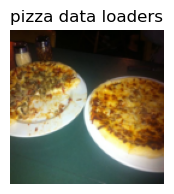

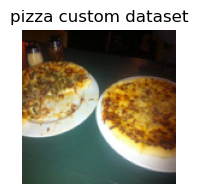

In [20]:
random_num = random.randint(0, 225)

img, label = train_data[random_num]
img_permute = img.permute(1, 2, 0)
class_dic = train_data.classes

img_custom, label_custom = train_data_custom[random_num]
img_permute_custom = img.permute(1, 2, 0)
class_dic_custom = train_data_custom.classes


plt.figure(figsize=(2, 2))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_dic[label] + " data loaders")

plt.figure(figsize=(2, 2))
plt.imshow(img_permute_custom)
plt.axis("off")
plt.title(class_dic_custom[label_custom] + " custom dataset");

## Augmenting Data

Increase the amount of data by creating "not new" data. Slightly tweaking existing data, or generate new data from existing data.

In the context of images, this could be slightly rotating, blurring, changing colors, changing perspective of our existing images.
<br>
Or use a AI to find patterns, and generate new images from our existing images.

Here are some visual examples of what they do: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [23]:
more_transforms = transforms.Compose([

    #Change the size
    transforms.Resize(size=(128, 128)),

    #Random application of a shit ton of jizz jazz
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
])

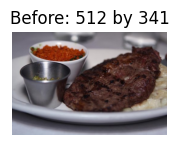

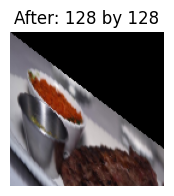

In [24]:
image_path = random.choice(image_path_list)
img = Image.open(image_path)
transformed_img = more_transforms(img)


plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis("off")
plt.title(f"Before: {img.width} by {img.height}")

plt.figure(figsize=(2, 2))
plt.imshow(transformed_img)
plt.axis("off")
plt.title(f"After: {transformed_img.width} by {transformed_img.height}");


# The Network

Again, just writing a CNN for practice on our custom dataset

If you want out model to run quicker (or just your code to run quicker), heres a website explaining the underlying principles: https://horace.io/brrr_intro.html

In [18]:
class TinyVGG(nn.Module):
    def __init__(self):
        super().__init__()

         #The in channels is no longer 1, as now we have 3 channels RGB from our input

        self.conv_b1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_b2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_b3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #again, we don't know the input size
        self.end_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2560, out_features=3), 
            nn.Softmax(dim=1)
        )

    #ok... it's not really just a image, when through all those convolution layers there's like 10 "feature" images running parallel
    def forward(self, image):
        image = self.conv_b1(image)
        image = self.conv_b2(image)
        image = self.conv_b3(image)
        output = self.end_classifier(image)
        return output
    
        #Alternatively, you can return it all in 1 go, so then we don't bother reassigning the value of "image", process "image" in gpu, update "image" in memory...
        #This one line of return just throws is all in 1 go
        #return self.end_classifier(self.conv_b3(self.conv_b2(self.conv_b1(image))))

model = TinyVGG().to(device)

## Network Description

The library `torchinfo` allows us to get a summary of our current network

In [25]:
from torchinfo import summary

summary(model=model, input_size=[1, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 10, 128, 128]         280
│    └─LeakyReLU: 2-2                    [1, 10, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 10, 128, 128]         910
│    └─LeakyReLU: 2-4                    [1, 10, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 10, 64, 64]           --
├─Sequential: 1-2                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 10, 64, 64]           910
│    └─LeakyReLU: 2-7                    [1, 10, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 10, 64, 64]           910
│    └─LeakyReLU: 2-9                    [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-10                   [1, 10, 32, 32]           --
├─Sequentia

# The Training/Testing

Setting up our data loaders again... from ImageFolder, Basically the entire process

In [26]:
from torchvision import datasets, transforms
import os
from torch.utils.data import DataLoader

data_path = Path("Data/")
train_dir = data_path/"train"
test_dir = data_path/"test"

data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=15),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)


Batch_size = 32
Num_Workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, batch_size=Batch_size, shuffle=True, num_workers=Num_Workers)
test_dataloader = DataLoader(dataset=test_data, batch_size=Batch_size, shuffle=False, num_workers=Num_Workers)

Trying a forward pass so we know what number we should put at the last linear layer

In [27]:
train_batch, label_batch = next(iter(train_dataloader))
model(train_batch.to(device))

tensor([[0.3277, 0.3367, 0.3356],
        [0.3276, 0.3367, 0.3357],
        [0.3278, 0.3367, 0.3355],
        [0.3277, 0.3366, 0.3357],
        [0.3277, 0.3367, 0.3356],
        [0.3276, 0.3368, 0.3356],
        [0.3277, 0.3367, 0.3356],
        [0.3276, 0.3368, 0.3356],
        [0.3276, 0.3367, 0.3358],
        [0.3276, 0.3368, 0.3356],
        [0.3276, 0.3368, 0.3356],
        [0.3276, 0.3367, 0.3356],
        [0.3276, 0.3367, 0.3357],
        [0.3277, 0.3366, 0.3357],
        [0.3276, 0.3368, 0.3356],
        [0.3277, 0.3367, 0.3356],
        [0.3277, 0.3366, 0.3357],
        [0.3277, 0.3367, 0.3356],
        [0.3277, 0.3367, 0.3357],
        [0.3277, 0.3368, 0.3356],
        [0.3277, 0.3367, 0.3356],
        [0.3276, 0.3366, 0.3358],
        [0.3277, 0.3367, 0.3356],
        [0.3278, 0.3367, 0.3355],
        [0.3277, 0.3368, 0.3356],
        [0.3277, 0.3367, 0.3357],
        [0.3275, 0.3368, 0.3357],
        [0.3277, 0.3367, 0.3356],
        [0.3277, 0.3367, 0.3356],
        [0.327

Then the long awaited loop

In [28]:
from tqdm.auto import tqdm


def train_step(model, data_loader, loss_fn, optimizer, device, epoch):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (image, label) in enumerate(data_loader):

        image, label = image.to(device), label.to(device)
        prediction = model(image)

        loss = loss_fn(prediction, label)
        train_loss += loss.item()

        prediction_label = torch.argmax(prediction, dim=1)
        train_acc += (prediction_label == label).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%")
    return train_loss, train_acc



def test_step(model, data_loader, loss_fn, device, epoch):

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (image, label) in enumerate(data_loader):

            image, label = image.to(device), label.to(device)
            prediction = model(image)
    
            loss = loss_fn(prediction, label)
            test_loss += loss.item()
    
            prediction_label = torch.argmax(prediction, dim=1)
            test_acc += (prediction_label == label).sum().item()

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Epoch: {epoch + 1} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")
    return test_loss, test_acc



def train(model, train, test, loss_fn, optimizer, device, epochs):

    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Train for however many epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train, loss_fn, optimizer, device, epoch)
        test_loss, test_acc = test_step(model, test, loss_fn, device, epoch)

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [29]:
# Set number of epochs
epochs = 10

# Recreate an instance of TinyVGG
Vision_Model = TinyVGG().to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Vision_Model.parameters(), lr=0.1)


train(Vision_Model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.12250 | Train Accuracy: 9.12%
Epoch: 1 | Test Loss: 1.00978 | Test Accuracy: 10.33%
Epoch: 2 | Train Loss: 1.27019 | Train Accuracy: 9.00%
Epoch: 2 | Test Loss: 1.00978 | Test Accuracy: 10.33%
Epoch: 3 | Train Loss: 1.17644 | Train Accuracy: 8.12%
Epoch: 3 | Test Loss: 1.35353 | Test Accuracy: 6.33%
Epoch: 4 | Train Loss: 1.25848 | Train Accuracy: 9.38%
Epoch: 4 | Test Loss: 1.35353 | Test Accuracy: 6.33%
Epoch: 5 | Train Loss: 1.25848 | Train Accuracy: 9.38%
Epoch: 5 | Test Loss: 1.35353 | Test Accuracy: 6.33%
Epoch: 6 | Train Loss: 1.25848 | Train Accuracy: 9.38%
Epoch: 6 | Test Loss: 1.35353 | Test Accuracy: 6.33%
Epoch: 7 | Train Loss: 1.25848 | Train Accuracy: 9.38%
Epoch: 7 | Test Loss: 1.35353 | Test Accuracy: 6.33%
Epoch: 8 | Train Loss: 1.25848 | Train Accuracy: 9.38%
Epoch: 8 | Test Loss: 1.35353 | Test Accuracy: 6.33%
Epoch: 9 | Train Loss: 1.13738 | Train Accuracy: 9.38%
Epoch: 9 | Test Loss: 1.35353 | Test Accuracy: 6.33%
Epoch: 10 | Train Loss: 1.

{'train_loss': [1.1225042194128036,
  1.270194873213768,
  1.176444873213768,
  1.258476123213768,
  1.258476123213768,
  1.258476123213768,
  1.258476123213768,
  1.258476123213768,
  1.137382373213768,
  1.137382373213768],
 'train_acc': [9.125,
  9.0,
  8.125,
  9.375,
  9.375,
  9.375,
  9.375,
  9.375,
  9.375,
  9.375],
 'test_loss': [1.0097782214482625,
  1.0097782214482625,
  1.3535282214482625,
  1.3535282214482625,
  1.3535282214482625,
  1.3535282214482625,
  1.3535282214482625,
  1.3535282214482625,
  1.3535282214482625,
  1.3535282214482625],
 'test_acc': [10.333333333333334,
  10.333333333333334,
  6.333333333333333,
  6.333333333333333,
  6.333333333333333,
  6.333333333333333,
  6.333333333333333,
  6.333333333333333,
  6.333333333333333,
  6.333333333333333]}

# OverFitting and UnderFitting

We know what they are, and yet both are really difficult to prevent

1. Overfitting is where the model performs well on training but poor on testing
2. Underfitting is where the model performs poor overall

<img src="Fitting.jpg" alt="The WorkFlow" width="1000">

Some Techniques For Overfitting

<img src="Over.png" alt="The WorkFlow" width="1000">

Some Techniques for UnderFitting

<img src="Under.png" alt="The WorkFlow" width="1000">